In [3]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.6 MB/s eta 0:00:00


In [18]:
import geopandas as gpd
import folium

def plot_customers_by_country(df):
    # Load the country polygons from the 'naturalearth_lowres' dataset
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Check the column name and rename if necessary
    if 'Geography' in df.columns:
        customers_by_country = df.groupby('Geography').agg({'Exited': 'sum', 'CustomerId': 'count'}).reset_index()
        customers_by_country.rename(columns={'CustomerId': 'Total_Customers'}, inplace=True)
        world_customers = world.merge(customers_by_country, left_on='name', right_on='Geography')
    elif 'Country' in df.columns:
        customers_by_country = df.groupby('Country').agg({'Exited': 'sum', 'CustomerId': 'count'}).reset_index()
        customers_by_country.rename(columns={'CustomerId': 'Total_Customers'}, inplace=True)
        world_customers = world.merge(customers_by_country, left_on='name', right_on='Country')

    # Create a map and add the customer count as a choropleth layer
    m = folium.Map(location=[48, 8], zoom_start=3)
    folium.Choropleth(
        geo_data=world_customers.to_json(),
        name='choropleth',
        data=world_customers,
        columns=['name', 'Exited'],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Number of exited customers'
    ).add_to(m)

    # Add markers for each country
    for i, row in world_customers.iterrows():
        popup_text = f"{row['name']}<br>" \
                     f"Exited: {row['Exited']}<br>" \
                     f"Stayed: {row['Total_Customers'] - row['Exited']}"
        folium.Marker(
            location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
            popup=popup_text,
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)

    # Add a layer control to the map
    folium.LayerControl().add_to(m)

    # Display the map
    return m


In [19]:
df = pd.read_csv('Churn_Modelling.csv')
plot_customers_by_country(df)

In [34]:
import seaborn as sns

def plot_correlation(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Create a figure with a single subplot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot the heatmap
    sns.heatmap(corr, annot=True, cmap='YlGnBu')

    # Add a title to the plot
    ax.set_title('Correlation Matrix')

    # Show the plot
    plt.show()

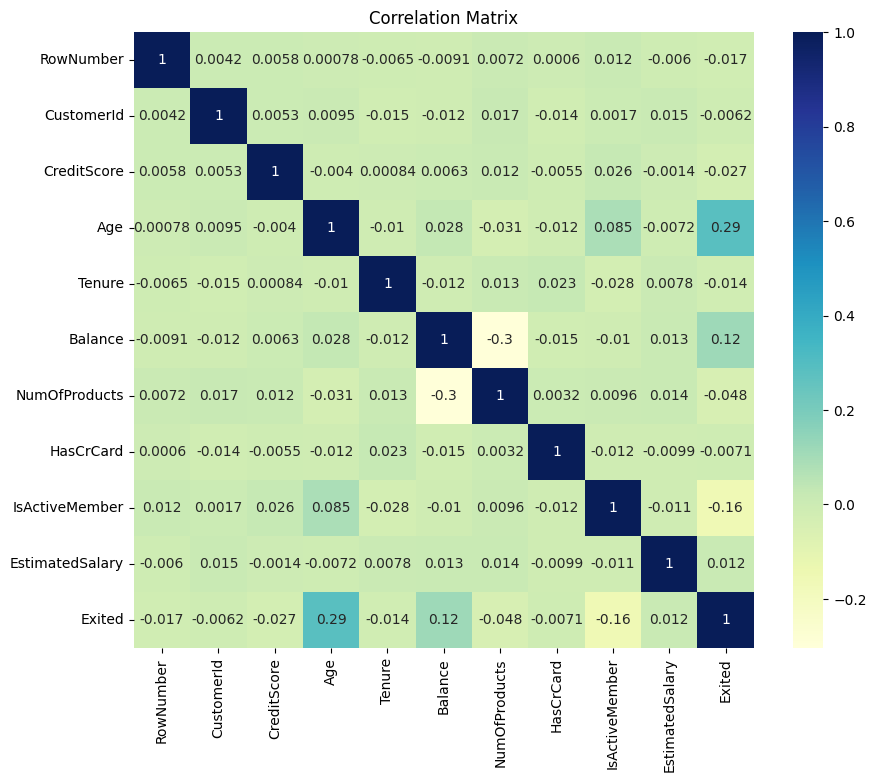

In [35]:
plot_correlation(df)

In [30]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

def plot_best_distribution(df):
    # Define the labels to plot
    labels = ['Exited', 'HasCrCard', 'IsActiveMember']

    # Define the distributions to test
    distributions = [
        st.beta,
        st.chi2,
        st.expon,
        st.gamma,
        st.lognorm,
        st.norm,
        st.pareto,
        st.uniform,
    ]

    # Plot the best distribution for each label
    for label in labels:
        plt.figure(figsize=(8, 6))
        data = df[label]
        best_dist = None
        best_params = {}
        best_score = np.inf
        for dist in distributions:
            # Fit the distribution to the data
            params = dist.fit(data)
            # Test the goodness of fit
            test_stat, p_value = st.kstest(data, dist.cdf, args=params)
            # Keep the best distribution based on the lowest test statistic
            if test_stat < best_score:
                best_dist = dist
                best_params = params
                best_score = test_stat
        # Plot the distribution
        sns.histplot(data, kde=False, stat='density')
        x_min, x_max = plt.xlim()
        x = np.linspace(x_min, x_max, 100)
        y = best_dist.pdf(x, *best_params)
        plt.plot(x, y, label=best_dist.name)
        plt.legend()
        plt.title(f'{label} Distribution')
        plt.xlabel(label)
        plt.ylabel('Density')
        plt.show()


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


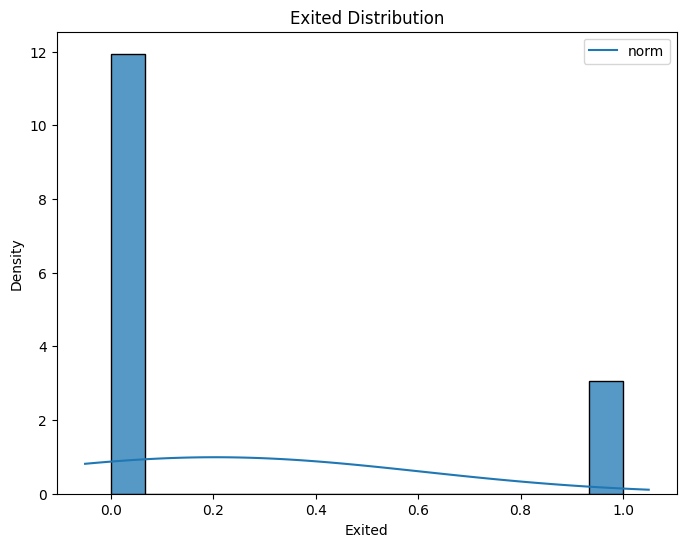

/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


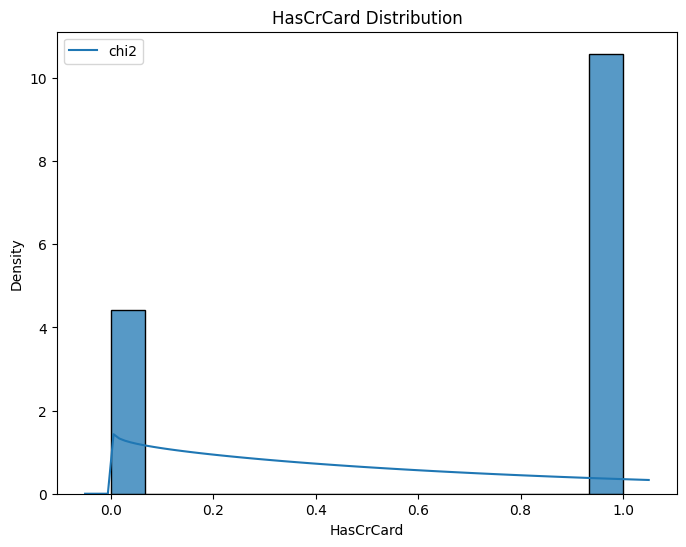

/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


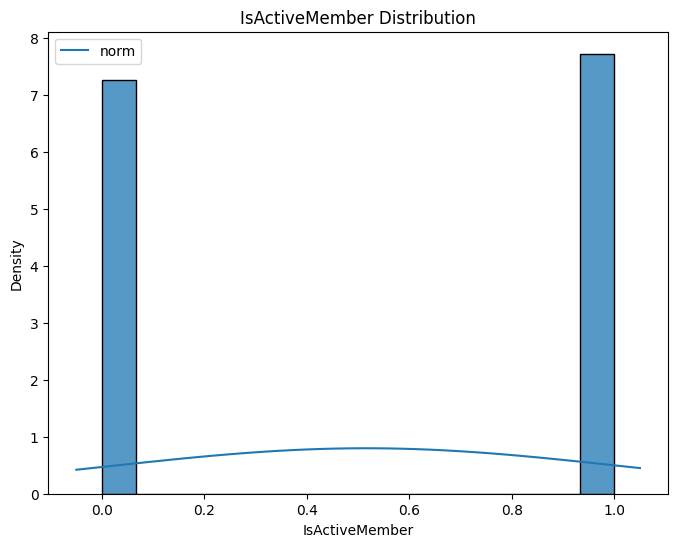

In [31]:
# Drop any rows with missing or infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Call the plot_best_distribution function with the cleaned dataframe
plot_best_distribution(df)


In [6]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset
df = pd.read_csv('Churn_Modelling.csv')

# Exploratory Data Analysis (EDA)
# Check for missing values
df.isnull().sum()

# Drop unnecessary columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Encoding categorical variables
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Splitting the dataset into features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Building the model - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)

# Evaluating the model
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))


[[1528   67]
 [ 200  205]]
Accuracy: 86.65%
